In [24]:
# ===============================================
# 📅 DAY 8 — ZERO-DAY ATTACK EVALUATION (XGBHybrid)
# ===============================================

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import xgboost as xgb
import matplotlib.pyplot as plt
import joblib

# ------------------------------------------------
# STEP 1 — Load full combined dataset
# ------------------------------------------------
base_dir = Path(r"C:\Users\cmhub\Desktop\network-anomaly-detector-starter\data\MachineLearningCSV\MachineLearningCVE")

files = {
    "Monday": "Monday-WorkingHours.pcap_ISCX.csv",
    "Tuesday": "Tuesday-WorkingHours.pcap_ISCX.csv",
    "Wednesday": "Wednesday-workingHours.pcap_ISCX.csv",
    "Thursday_Morning": "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
    "Thursday_Afternoon": "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
    "Friday_Morning": "Friday-WorkingHours-Morning.pcap_ISCX.csv",
    "Friday_Afternoon": "Friday-WorkingHours-Morning.pcap_ISCX.csv"
}

dfs = []
for day, filename in files.items():
    df_day = pd.read_csv(base_dir / filename)
    df_day.columns = df_day.columns.str.strip()
    if " Label" in df_day.columns:
        df_day = df_day.rename(columns={" Label": "Label"})
    df_day.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_day = df_day.fillna(0)
    df_day["Day"] = day
    dfs.append(df_day)

full_df = pd.concat(dfs, ignore_index=True)
full_df["Label"] = full_df["Label"].apply(lambda x: 0 if x == "BENIGN" else 1)

print(f"Combined dataset shape: {full_df.shape}")















Combined dataset shape: (2509564, 80)


In [25]:
# ------------------------------------------------
# STEP 2 — Build a realistic Zero-Day test set
# ------------------------------------------------
ZERO_DAY_ATTACK_NAME = "Infiltration"

# 1️⃣ Get all attack samples from Thursday_Afternoon (Infiltration)
attack_zero = full_df[
    (full_df["Label"] == 1) &
    (full_df["Day"].str.contains("Thursday_Afternoon", case=False))
].copy()

# 2️⃣ Add equal benign samples from other days for contrast
benign_zero = full_df[
    (full_df["Label"] == 0) &
    (~full_df["Day"].str.contains("Thursday_Afternoon", case=False))
].sample(n=len(attack_zero), random_state=42)

# 3️⃣ Combine and shuffle the zero-day test
zero_day_test = pd.concat([attack_zero, benign_zero]).sample(frac=1, random_state=42)

# 4️⃣ Everything except Thursday_Afternoon used for training
train_df = full_df[
    ~full_df["Day"].str.contains("Thursday_Afternoon", case=False)
].copy()

print(f"Zero-day attack samples: {len(attack_zero)} | Benign samples: {len(benign_zero)}")
print(f"Total zero-day test set size: {len(zero_day_test)}")

# Feature/label splits
X_zero = zero_day_test.drop(columns=["Label", "Day"])
y_zero = zero_day_test["Label"]

Zero-day attack samples: 36 | Benign samples: 36
Total zero-day test set size: 72


In [26]:
# ------------------------------------------------
# STEP 3 — Standard scaling
# ------------------------------------------------
scaler = StandardScaler()

X_train = train_df.drop(columns=["Label", "Day"])
y_train = train_df["Label"]

X_train_scaled = scaler.fit_transform(X_train)
X_zero_scaled = scaler.transform(X_zero)

In [27]:
# ------------------------------------------------
# STEP 4 — Train new autoencoder on known traffic
# ------------------------------------------------
input_dim = X_train_scaled.shape[1]
encoding_dim = input_dim // 2

autoencoder = Sequential([
    Dense(encoding_dim, activation="relu", input_shape=(input_dim,)),
    Dense(encoding_dim // 2, activation="relu"),
    Dense(encoding_dim, activation="relu"),
    Dense(input_dim, activation="linear")
])

autoencoder.compile(optimizer="adam", loss="mse")

autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=15,
    batch_size=512,
    shuffle=True,
    validation_split=0.1,
    verbose=1
)

# Reconstruction errors (added as hybrid feature)
train_recon = np.mean(np.square(X_train_scaled - autoencoder.predict(X_train_scaled)), axis=1)
zero_recon = np.mean(np.square(X_zero_scaled - autoencoder.predict(X_zero_scaled)), axis=1)

X_train_hybrid = X_train.copy()
X_train_hybrid["reconstruction_error"] = train_recon

X_zero_hybrid = X_zero.copy()
X_zero_hybrid["reconstruction_error"] = zero_recon

C:\Users\cmhub\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
3905/3905 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.1766 - val_loss: 0.0414
Epoch 2/15
3905/3905 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0826 - val_loss: 0.0278
Epoch 3/15
3905/3905 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0632 - val_loss: 0.0216
Epoch 4/15
3905/3905 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0523 - val_loss: 0.0175
Epoch 5/15
3905/3905 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0395 - val_loss: 0.0176
Epoch 6/15
3905/3905 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0364 - val_loss: 0.0182
Epoch 7/15
3905/3905 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0326 - val_loss: 0.0136
Epoch 8/15
3905/3905 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0256 - val_loss: 0.0110
Epoch 9/15
3905/3905 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0245 - val_loss: 0.0112
Epoch 10/15
3905/3905 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0217 - val_loss: 0.0131
Epoch 11/15
3905/3905 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0208 - val_loss: 0.0096
Epoch 12/15
3905/3905 ━━━━━━━━

In [28]:
# ------------------------------------------------
# STEP 5 — Balance known attack dataset
# ------------------------------------------------
train_combined = pd.concat([X_train_hybrid, y_train], axis=1)
attack_df = train_combined[train_combined["Label"] == 1]
benign_df = train_combined[train_combined["Label"] == 0]

ratio = 3  # 3 benign per attack
n_samples = min(len(attack_df) * ratio, len(benign_df))
benign_down = resample(benign_df, replace=False, n_samples=n_samples, random_state=42)

train_balanced = pd.concat([attack_df, benign_down]).sample(frac=1, random_state=42)
y_train_bal = train_balanced["Label"]
X_train_bal = train_balanced.drop(columns=["Label"])


In [29]:
# ------------------------------------------------
# STEP 6 — Train the hybrid XGBoost model
# ------------------------------------------------
xgb_hybrid = xgb.XGBClassifier(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=len(y_train_bal[y_train_bal==0]) / len(y_train_bal[y_train_bal==1]),
    n_jobs=-1,
    eval_metric="auc",
    random_state=42
)

xgb_hybrid.fit(X_train_bal, y_train_bal)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'



=== Zero-Day Attack Evaluation ===
ROC-AUC (Zero-Day): 0.899
PR-AUC (Zero-Day):  0.847

Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67        36
           1       0.00      0.00      0.00        36

    accuracy                           0.50        72
   macro avg       0.25      0.50      0.33        72
weighted avg       0.25      0.50      0.33        72



C:\Users\cmhub\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\cmhub\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\cmhub\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_clas

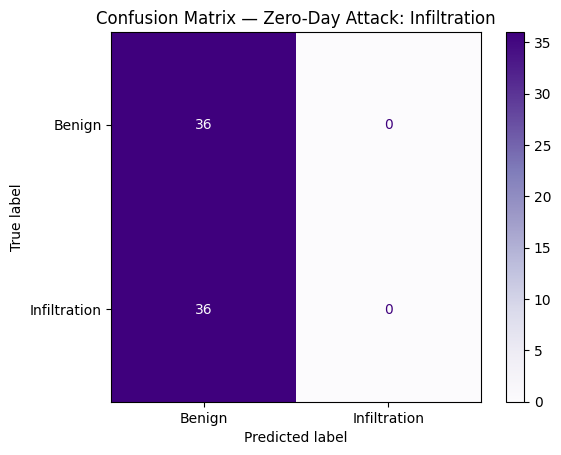

In [30]:
# ------------------------------------------------
# STEP 7 — Evaluate on Zero-Day attack samples
# ------------------------------------------------
y_pred_zero = xgb_hybrid.predict(X_zero_hybrid)
y_proba_zero = xgb_hybrid.predict_proba(X_zero_hybrid)[:, 1]

roc_auc_zero = roc_auc_score(y_zero, y_proba_zero)
pr_auc_zero = average_precision_score(y_zero, y_proba_zero)

print("\n=== Zero-Day Attack Evaluation ===")
print(f"ROC-AUC (Zero-Day): {roc_auc_zero:.3f}")
print(f"PR-AUC (Zero-Day):  {pr_auc_zero:.3f}")
print("\nClassification Report:\n", classification_report(y_zero, y_pred_zero))

cm_zero = confusion_matrix(y_zero, y_pred_zero)
ConfusionMatrixDisplay(confusion_matrix=cm_zero, display_labels=["Benign", ZERO_DAY_ATTACK_NAME]).plot(cmap='Purples')
plt.title(f"Confusion Matrix — Zero-Day Attack: {ZERO_DAY_ATTACK_NAME}")
plt.show()

In [31]:
# ------------------------------------------------
# STEP 8 — Compare against full-knowledge model
# ------------------------------------------------
full_model = xgb.XGBClassifier()
full_model.load_model(r"C:\Users\cmhub\Desktop\network-anomaly-detector-starter\models\xgboost_hybrid_model.json")

scaler_full = joblib.load(r"C:\Users\cmhub\Desktop\network-anomaly-detector-starter\models\xgboost_hybrid_scaler.pkl")

X_zero_scaled_full = scaler_full.transform(X_zero)
zero_recon_full = np.mean(np.square(X_zero_scaled_full - autoencoder.predict(X_zero_scaled_full)), axis=1)

X_zero_hybrid_full = X_zero.copy()
X_zero_hybrid_full["reconstruction_error"] = zero_recon_full

y_proba_full = full_model.predict_proba(X_zero_hybrid_full)[:, 1]
roc_auc_full = roc_auc_score(y_zero, y_proba_full)
pr_auc_full = average_precision_score(y_zero, y_proba_full)

summary_df = pd.DataFrame({
    'Metric': ['ROC-AUC', 'PR-AUC'],
    'Full Knowledge Model': [roc_auc_full, pr_auc_full],
    f'Zero-Day Model ({ZERO_DAY_ATTACK_NAME})': [roc_auc_zero, pr_auc_zero]
})

print("\n=== Zero-Day Comparison Summary ===")
print(summary_df.to_string(index=False))
summary_df.to_csv(f"zero_day_results_{ZERO_DAY_ATTACK_NAME}.csv", index=False)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

=== Zero-Day Comparison Summary ===
 Metric  Full Knowledge Model  Zero-Day Model (Infiltration)
ROC-AUC                   1.0                       0.898920
 PR-AUC                   1.0                       0.847346


In [32]:
# ===============================================
# STEP 9 — Zero-Day Threshold Analysis
# ===============================================

from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_zero, y_proba_zero)

# Compute F1 for each possible threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]

print(f"Optimal threshold (max F1): {best_thresh:.3f}")
print(f"Precision: {precision[best_idx]:.3f} | Recall: {recall[best_idx]:.3f}")

# Apply the optimized threshold
y_pred_zero_opt = (y_proba_zero >= best_thresh).astype(int)



Optimal threshold (max F1): 0.000
Precision: 0.791 | Recall: 0.944


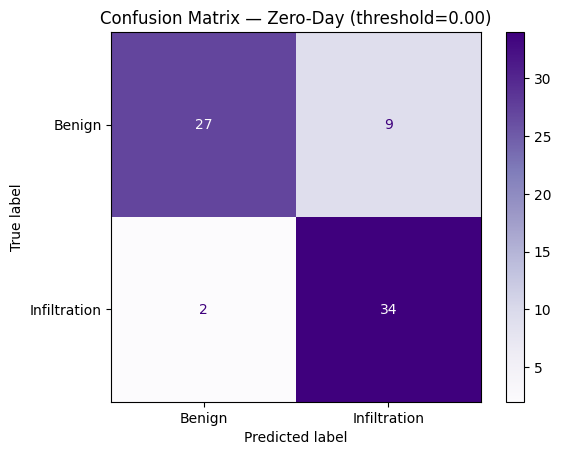

In [33]:
# Confusion matrix using optimized threshold
cm_opt = confusion_matrix(y_zero, y_pred_zero_opt)
ConfusionMatrixDisplay(confusion_matrix=cm_opt,
                       display_labels=["Benign", ZERO_DAY_ATTACK_NAME]).plot(cmap="Purples")

plt.title(f"Confusion Matrix — Zero-Day (threshold={best_thresh:.2f})")
plt.show()


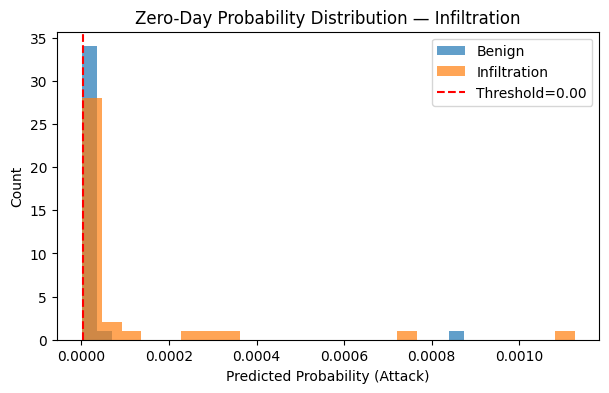

In [34]:
# Probability distribution plot for zero-day detection
plt.figure(figsize=(7,4))
plt.hist(y_proba_zero[y_zero==0], bins=25, alpha=0.7, label="Benign")
plt.hist(y_proba_zero[y_zero==1], bins=25, alpha=0.7, label=ZERO_DAY_ATTACK_NAME)
plt.axvline(best_thresh, color='red', linestyle='--', label=f"Threshold={best_thresh:.2f}")
plt.legend()
plt.xlabel("Predicted Probability (Attack)")
plt.ylabel("Count")
plt.title(f"Zero-Day Probability Distribution — {ZERO_DAY_ATTACK_NAME}")
plt.show()


In [2]:
# --- Day 8.5: Build and verify hybrid-ready dataset ---
import os
import pandas as pd
import numpy as np
import joblib
import xgboost as xgb
from tensorflow.keras.models import load_model

print("🔧 Rebuilding hybrid-ready dataset...\n")

# --- Paths ---
base_dir = r"C:\Users\cmhub\Desktop\network-anomaly-detector-starter\data\MachineLearningCSV\MachineLearningCVE"
clean_path = os.path.join(base_dir, "CICIDS2017_clean_binary.csv")
auto_path  = r"C:\Users\cmhub\Desktop\network-anomaly-detector-starter\models\autoencoder_model.keras"
scaler_path = r"C:\Users\cmhub\Desktop\network-anomaly-detector-starter\models\autoencoder_scaler.pkl"
xgb_path    = r"C:\Users\cmhub\Desktop\network-anomaly-detector-starter\models\xgboost_hybrid_model.json"
save_path   = os.path.join(base_dir, "CICIDS2017_hybrid_ready.csv")

# --- 1. Load base dataset ---
df = pd.read_csv(clean_path)
print(f"Loaded clean dataset: {df.shape}")

# --- 2. Load autoencoder & scaler ---
autoencoder = load_model(auto_path)
scaler = joblib.load(scaler_path)
print("Models loaded successfully.\n")

# --- 3. Select numeric features and scale ---
X = df.drop(columns=["Label"], errors="ignore").select_dtypes(include=[np.number])
X_scaled = scaler.transform(X)

# --- 4. Compute reconstruction error (mean squared) ---
reconstructions = autoencoder.predict(X_scaled, verbose=0)
reconstruction_error = np.mean(np.square(X_scaled - reconstructions), axis=1)
df["reconstruction_error"] = reconstruction_error
print(f"Added reconstruction_error feature. New shape: {df.shape}\n")

# --- 5. Load trained hybrid model to verify feature match ---
xgb_model = xgb.XGBClassifier()
xgb_model.load_model(xgb_path)
model_features = xgb_model.get_booster().feature_names
missing = set(model_features) - set(df.drop(columns=["Label"]).columns)
extra   = set(df.drop(columns=["Label"]).columns) - set(model_features)

if missing:
    print(f"⚠️ Missing features in dataset: {missing}")
if extra:
    print(f"ℹ️ Extra features not in model (ignored at inference): {extra}")
else:
    print("✅ Feature alignment with model verified.\n")

# --- 6. Save finalized dataset ---
os.makedirs(os.path.dirname(save_path), exist_ok=True)
df.to_csv(save_path, index=False)
print(f"✅ Saved hybrid-ready dataset to:\n{save_path}")


🔧 Rebuilding hybrid-ready dataset...

Loaded clean dataset: (2604998, 79)
Models loaded successfully.

Added reconstruction_error feature. New shape: (2604998, 80)

✅ Feature alignment with model verified.

✅ Saved hybrid-ready dataset to:
C:\Users\cmhub\Desktop\network-anomaly-detector-starter\data\MachineLearningCSV\MachineLearningCVE\CICIDS2017_hybrid_ready.csv


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

# --- Retrain hybrid XGBoost on the new dataset ---
X = df.drop(columns=['Label'])
y = df['Label']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train model with reconstruction_error included
xgb_hybrid = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
    n_jobs=-1,
    eval_metric='auc',
    random_state=42
)

xgb_hybrid.fit(X_train, y_train)

# Evaluate
y_pred = xgb_hybrid.predict(X_test)
y_proba = xgb_hybrid.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Save updated model
xgb_hybrid.save_model(r"C:\Users\cmhub\Desktop\network-anomaly-detector-starter\models\xgboost_hybrid_model.json")
print("✅ Retrained and saved updated hybrid model (includes reconstruction_error).")


Accuracy: 0.9989980806142035
ROC-AUC: 0.9999534290158306

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    435076
           1       0.99      1.00      1.00     85924

    accuracy                           1.00    521000
   macro avg       1.00      1.00      1.00    521000
weighted avg       1.00      1.00      1.00    521000



AttributeError: 'XGBClassifier' object has no attribute 'save_scaler'

In [ ]:
# === Rebuild and Save Scaler with reconstruction_error ===
import pandas as pd
from sklearn.preprocessing import StandardScaler
import joblib

# Load hybrid dataset that includes reconstruction_error
hybrid_path = r"data/MachineLearningCSV/MachineLearningCVE/CICIDS2017_hybrid_ready.csv"
df_hybrid = pd.read_csv(hybrid_path)

# Drop the label (scaler only fits on features)
X_hybrid = df_hybrid.drop(columns=["Label"])

# Refit the scaler on all 79 features (including reconstruction_error)
scaler = StandardScaler()
scaler.fit(X_hybrid)

# Save the updated scaler to models/
joblib.dump(scaler, r"C:\Users\cmhub\Desktop\network-anomaly-detector-starter\models\xgboost_hybrid_scaler.pkl")

print(f"✅ Scaler retrained on {X_hybrid.shape[1]} features (including reconstruction_error).")
print("Scaler saved successfully → models/scaler.pkl")
